# Gradient descent algorithm for Scenario 2


In this part, we implement an gradient descent algorithm to optimization the objective loss function in Scenario 2:


$$\min F := \min \frac{1}{2(n-i)} \sum_{i=1000}^n (fbpredic(i) + a*tby(i) +b*ffr(i) + c*fta(i) - asp(i))^2$$

Gradient descent: 

$$ \beta_k = \beta_{k-1} + \delta* \nabla F, $$
where $\delta$ control how far does each iteration go.


### Detailed plan

First, split the data as train and test with 80% and 20% respectively. For the training part, we need prophet() predicted price, there are a couple of issues. One is prophet() can not predict too far in the future. The other is we can not call prophet() too many times, this takes a lot of time. So we will use a sliding window strategy:

1, Split the train data as train_1 and train_2, where train_1 is used as a sliding window to fit prophet(), and give predictions in train_2. Train_2 is used train the model we proposed above.

2, After we got full size (size of train_2) predictions from prophet(), then we use gradient descent to fit the above model, extracting the coefficients of features to make predicution in the testing data.

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from numpy import meshgrid

## For plotting
import matplotlib.pyplot as plt
from matplotlib import style
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")

In [26]:
df= pd.read_csv('df4.csv', parse_dates=['Date'])
df = df.rename(columns = {"Date":"ds","Close":"y"}) 
df 
len(df)

4520

In [31]:
from datetime import datetime
p = 0.9
# Train around 90% of dataset 
cutoff = int((p*len(df)//100)*100)
df_train = df[:cutoff].copy()
df_test = df.drop(df_train.index).copy()

print(df_train, df_test)

             ds        y   tby   ffr        fta     eps   div
0    2003-01-02   909.03  4.07  1.24   732202.0   40.40  1.79
1    2003-01-03   908.59  4.05  1.24   732202.0   40.40  1.79
2    2003-01-06   929.01  4.09  1.24   732202.0   40.40  1.79
3    2003-01-07   922.93  4.04  1.24   732202.0   40.40  1.79
4    2003-01-08   909.93  4.00  1.24   724902.0   40.40  1.79
...         ...      ...   ...   ...        ...     ...   ...
3995 2018-12-24  2351.10  2.74  2.27  4084274.0  138.43  1.96
3996 2018-12-26  2467.70  2.81  2.27  4075636.0  138.43  1.96
3997 2018-12-27  2488.83  2.77  2.27  4075636.0  138.43  1.96
3998 2018-12-28  2485.74  2.72  2.27  4075636.0  138.43  1.96
3999 2018-12-31  2506.85  2.69  2.27  4075636.0  139.58  2.09

[4000 rows x 7 columns]              ds        y   tby   ffr        fta     eps   div
4000 2019-01-02  2510.03  2.66  2.40  4058378.0  139.58  2.09
4001 2019-01-03  2447.89  2.56  2.40  4058378.0  139.58  2.09
4002 2019-01-04  2531.94  2.67  2.40  4058378

 Use prophet() to make predictions, we will split training as train_1 and train_2 with ratio 40% vs 60%, 
 train_1 will be used to fit prophet(), then predict on train_2.  Getting the predictions, feed the data into
 the Scenario 2 model, train again to get the parameters a,b,c,....

In [5]:
import trading_calendars as tc
import pandas as pd
import pytz
xnys = tc.get_calendar('XNYS')

# drop non-trading days from the forecast
def pred_yhat(df, sz):
    trading_days = [x for x in df.ds if xnys.is_session(x)]
    idx = [i for i in df.index if df.ds[i] in trading_days]
    df = df.loc[idx, ]
    return df.yhat[:sz]

In [28]:
#prophet part 
from fbprophet import Prophet
start = 1000 # the number of initial data for training 
pred_size =100 # predicted periods 
num_winds = int((df_train.shape[0]-start)/pred_size) #(4000-3000)/100 =30

pro_pred = []

# use accumulated data to predict the next pred_size data
for i in range(num_winds):
    tmp_train = df_train.iloc[: start+ i*pred_size].copy()
    
    fbp = Prophet(daily_seasonality=True)
    # fit close price using fbprophet model
    fbp.fit(tmp_train[['ds','y']])
    
    # predict 3*pred_size futures and get the forecast price 
    fut = fbp.make_future_dataframe(periods = 3 * pred_size,)
    tmp_forecast = fbp.predict(fut) 
    
    # return pred_size many data in trading data
    pred = pred_yhat(tmp_forecast[start+ i*pred_size:], pred_size)
    pro_pred.append(pred)
    

<ipython-input-5-606d19f6c2e7>:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  trading_days = [x for x in df.ds if xnys.is_session(x)]
<ipython-input-5-606d19f6c2e7>:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  trading_days = [x for x in df.ds if xnys.is_session(x)]
<ipython-input-5-606d19f6c2e7>:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  trading_days = [x for x in df.ds if xnys.is_session(x)]
<ipython-input-5-606d19f6c2e7>:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future versi

In [32]:
pro_pred

[1004    1448.084488
 1005    1449.451556
 1006    1450.261373
 1009    1453.282265
 1010    1454.366140
            ...     
 1142    1444.898602
 1143    1444.985922
 1144    1445.125831
 1145    1445.127082
 1146    1444.804284
 Name: yhat, Length: 100, dtype: float64,
 1103    1512.327591
 1104    1514.816167
 1105    1516.756794
 1106    1518.382992
 1109    1524.377411
            ...     
 1238    1649.841219
 1239    1649.968165
 1242    1651.677851
 1243    1652.722857
 1244    1654.198371
 Name: yhat, Length: 100, dtype: float64,
 1200    1514.578122
 1203    1514.530661
 1204    1514.809543
 1205    1515.923340
 1206    1516.355229
            ...     
 1340    1591.431247
 1343    1590.139113
 1344    1590.020725
 1345    1590.750836
 1346    1590.814107
 Name: yhat, Length: 100, dtype: float64,
 1302    1336.871957
 1303    1337.544040
 1304    1340.170585
 1305    1341.403327
 1309    1347.529845
            ...     
 1438    1397.416730
 1439    1395.025333
 1442    1391

In [33]:
flat_pro_pred = [item for l1 in pro_pred for item in l1]

In [34]:
df.columns

Index(['ds', 'y', 'tby', 'ffr', 'fta', 'eps', 'div'], dtype='object')

In [35]:
def powerset_no_empty(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
            
    return power_set[1:]

possible_features = powerset_no_empty(['tby', 'ffr', 'fta', 'eps', 'div'])

In [37]:
print(len(possible_features))
possible_features

31


[['tby'],
 ['ffr'],
 ['tby', 'ffr'],
 ['fta'],
 ['tby', 'fta'],
 ['ffr', 'fta'],
 ['tby', 'ffr', 'fta'],
 ['eps'],
 ['tby', 'eps'],
 ['ffr', 'eps'],
 ['tby', 'ffr', 'eps'],
 ['fta', 'eps'],
 ['tby', 'fta', 'eps'],
 ['ffr', 'fta', 'eps'],
 ['tby', 'ffr', 'fta', 'eps'],
 ['div'],
 ['tby', 'div'],
 ['ffr', 'div'],
 ['tby', 'ffr', 'div'],
 ['fta', 'div'],
 ['tby', 'fta', 'div'],
 ['ffr', 'fta', 'div'],
 ['tby', 'ffr', 'fta', 'div'],
 ['eps', 'div'],
 ['tby', 'eps', 'div'],
 ['ffr', 'eps', 'div'],
 ['tby', 'ffr', 'eps', 'div'],
 ['fta', 'eps', 'div'],
 ['tby', 'fta', 'eps', 'div'],
 ['ffr', 'fta', 'eps', 'div'],
 ['tby', 'ffr', 'fta', 'eps', 'div']]

In [38]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False, normalize=True, copy_X = True)
reg.fit(df_train[start:cutoff][possible_features[30]], df_train[start:cutoff]['y'] - flat_pro_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [45]:
coef = []
t=30
for i in range(len(possible_features[t])):
    coef.append(np.round(reg.coef_[i],5))

print(coef)

[115.58087, -31.22849, 8e-05, -2.28486, -146.51735]


In [40]:
# Forecast the Test Data
from fbprophet import Prophet
test_time = int((1-p)* len(df))
fbp = Prophet(daily_seasonality=True)
fbp.fit(df_train[['ds','y']])
fut = fbp.make_future_dataframe(periods = 3 * test_time,)
forecast = fbp.predict(fut)

pred_test = pred_yhat(forecast[cutoff:], test_time)
pred_test = pred_test.ravel()

<ipython-input-5-606d19f6c2e7>:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  trading_days = [x for x in df.ds if xnys.is_session(x)]


In [47]:
len(pred_test)

451

In [42]:
pp_test = pred_test.copy() # predicted price after tuning the features on testing data 
pp_train = flat_pro_pred.copy() # predicted price after tuning the features on training data 
for i in range(len(possible_features[t])):
    pp_test += coef[i] * df_test[df_test.columns[i+2]][:test_time].ravel()
    pp_train += coef[i] * df_train[df_train.columns[i+2]][start:].ravel()


In [43]:
from sklearn.metrics import mean_squared_error as MSE
# MSE for test data
# Actual close price: df_test[:test_time].y 
# Predicted price by prophet: pred_test
# Predicted price by tuning features: pp_test
mse1 = MSE(df_test[:test_time].y,pred_test) #
mse2 = MSE(df_test[:test_time].y, pp_test)
print(mse1,mse2)

55503.903555627076 53520.10547925214


In [44]:
# MSE for train data
mse3 = MSE(df_train[start:].y, flat_pro_pred)
mse4 = MSE(df_train[start:].y, pp_train)
print(mse3,mse4)

28008.921725650445 21671.876704478625


In [48]:
flat_pro_pred

[1448.084487765342,
 1449.4515564709955,
 1450.261373422307,
 1453.2822645862989,
 1454.3661402775242,
 1455.2201789423716,
 1455.648544194409,
 1455.466859964995,
 1455.4213171382096,
 1455.2850178870776,
 1454.77992843184,
 1453.7397776926282,
 1451.6736942807759,
 1451.3215513846003,
 1450.9171613899553,
 1450.2889350452062,
 1449.272911829621,
 1448.1384366575967,
 1448.3594711706362,
 1448.6403134858417,
 1448.7938549827481,
 1448.638414262971,
 1450.356877425671,
 1451.5471211252282,
 1452.7694744888913,
 1453.815376689681,
 1454.4828231307315,
 1458.076505667088,
 1459.646843251732,
 1461.1102168080358,
 1462.252813767093,
 1462.870702310805,
 1466.4511653557918,
 1467.2187166024405,
 1467.573551611142,
 1467.3295333778094,
 1467.0943758382843,
 1467.1185038020874,
 1466.9551022578253,
 1466.4254970928887,
 1465.3613753189038,
 1463.2001500330887,
 1462.7975117049639,
 1462.3266430194863,
 1461.6114488669446,
 1460.4832081960944,
 1458.8116766975363,
 1458.7711710002484,
 1458.7

In [28]:
# df_train['pp']=pd.Series(np.append([np.nan for i in range(1000)], pp_train))

In [46]:
# plt.figure(figsize=(11,6))
# # plt.plot(range(1000,4000),df[1000:4000].fbsp,label='fb predicted price on test_data')
# plt.plot(range(1000,4000),df_train[1000:].pp,label="fitted values by our model")
# plt.plot(range(1000,4000), df_train[1000:].y   ,label='ture price value')
# plt.legend(fontsize=13)

# plt.title("Fitting on the training data",fontsize=18)

Text(0.5, 1.0, 'Prediction on the testing data')

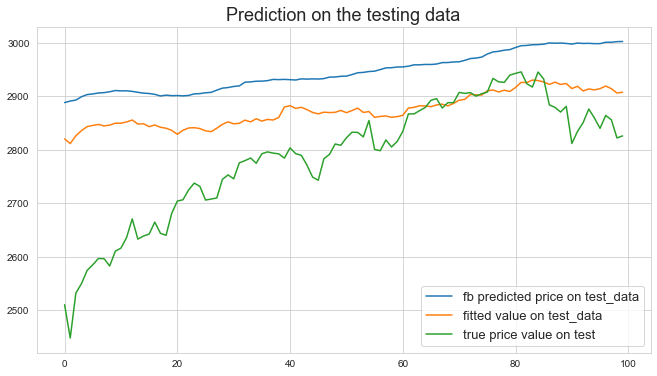

In [31]:
# plt.figure(figsize=(11,6))
# plt.plot(range(0,test_time),pd.Series(pred_test),label='fb predicted price on test_data')

# plt.plot(range(0,test_time),pd.Series(pp_test),label='fitted value on test_data')
# plt.plot(range(0,test_time),  df_test[:test_time].y,label='true price value on test')

# plt.legend(fontsize=13)
# plt.title("Prediction on the testing data",fontsize=18)